In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 3)
float64
(262407, 1)
float64


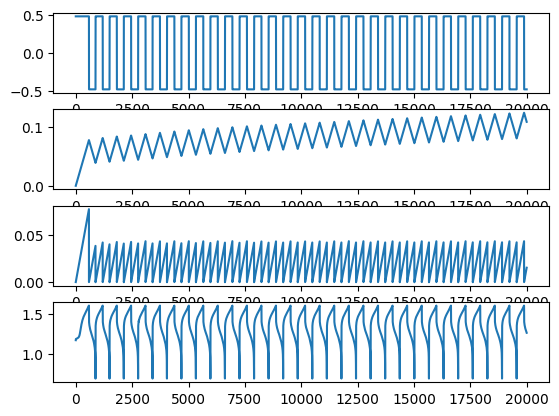

In [4]:
plt.subplot(4,1,1)
plt.plot(dataset.x[:20000,:1].squeeze())
plt.subplot(4,1,2)
plt.plot(dataset.x[:20000,1:2].squeeze())
plt.subplot(4,1,3)
plt.plot(dataset.x[:20000,2:3].squeeze())
plt.subplot(4,1,4)
plt.plot(dataset.y[:20000].squeeze())
plt.show()

In [5]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=4)

In [7]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [8]:
num_epochs = 1
learning_rate = 0.001

input_size = 3
hidden_size = 16
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1]).to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [10]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


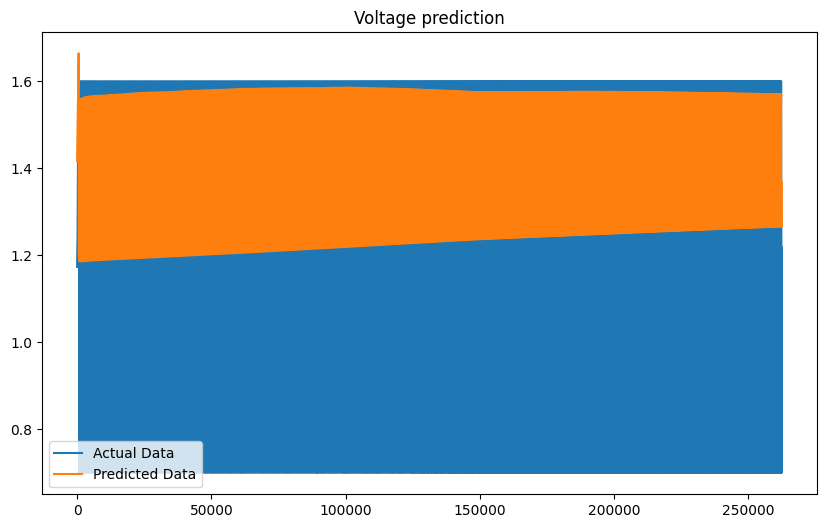

In [ ]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))
X1 = X1.to(device)

Y = torch.Tensor(dataset.y)

train_predict = model(X1)

train_predict = train_predict.to('cpu')
predicted = train_predict.data.numpy()
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Voltage prediction')
plt.legend()
plt.show()